# 技术分析策略和交易系统-布林带指标

In [5]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.sans-serif'] = ['SimHei']

## 1.数据准备

In [6]:
# 获取数据
stock_index = ts.get_k_data('hs300','2019-01-01','2020-01-01')
stock_index['date'] = pd.to_datetime(stock_index['date'])
stock_index.set_index('date',inplace=True)
stock_index.head()

,open,close,high,low,volume,code
date,,,,,,
2019-01-02,3017.07,2969.54,3018.78,2958.49,68663021.0,hs300
2019-01-03,2963.02,2964.84,3000.44,2953.25,70867103.0,hs300
2019-01-04,2940.19,3035.87,3036.81,2935.83,103318972.0,hs300
2019-01-07,3055.15,3054.30,3061.75,3035.91,101164359.0,hs300
2019-01-08,3049.87,3047.70,3055.51,3038.53,86170585.0,hs300


In [7]:
stock_index['upper'], stock_index['middle'], stock_index['lower'] = ta.BBANDS(np.asarray(stock_index['close']),
timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

No handles with labels found to put in legend.


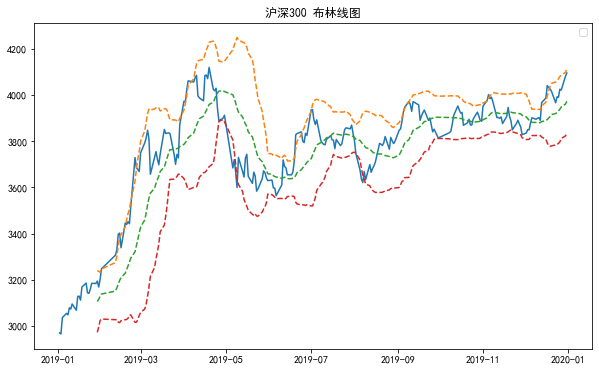

In [9]:
fig = plt.figure(figsize= (10,6))
plt.plot(stock_index['close'])
plt.plot(stock_index['upper'], linestyle='--')
plt.plot(stock_index['middle'], linestyle='--')
plt.plot(stock_index['lower'], linestyle='--')
plt.title('沪深300 布林线图')
plt.legend()

### 2.交易信号和持仓信号计算（分开计算）

In [11]:
stock_index['yes_close'] = stock_index['close'].shift(1)
stock_index['yes_lower'] = stock_index['lower'].shift(1)
stock_index['yes_upper'] = stock_index['upper'].shift(1)
stock_index['byes_close'] = stock_index['close'].shift(2)
stock_index['byes_lower'] = stock_index['lower'].shift(2)
stock_index['byes_upper'] = stock_index['upper'].shift(2)

In [12]:
stock_index['signal'] = np.where(np.logical_and(stock_index['byes_close'] < stock_index['byes_lower'],
                                               stock_index['yes_close'] > stock_index['yes_lower']), 1, 0)
stock_index['signal'] = np.where(np.logical_and(stock_index['byes_close'] > stock_index['byes_upper'],
                                               stock_index['yes_close'] < stock_index['yes_upper']), -1, stock_index['signal'])

In [13]:
stock_index.tail()

,open,close,high,low,volume,code,upper,middle,lower,yes_close,yes_lower,yes_upper,byes_close,byes_lower,byes_upper,signal
date,,,,,,,,,,,,,,,,
2019-12-25,3988.66,3990.87,4000.56,3976.36,94938890.0,hs300,4071.171302,3931.2485,3791.325698,3992.96,3786.369049,4064.602951,3967.10,3784.151223,4056.689777,0
2019-12-26,3993.67,4025.99,4025.99,3993.54,108860640.0,hs300,4081.400805,3939.4330,3797.465195,3990.87,3791.325698,4071.171302,3992.96,3786.369049,4064.602951,0
2019-12-27,4029.25,4022.03,4066.80,4019.72,150926411.0,hs300,4085.818742,3949.1010,3812.383258,4025.99,3797.465195,4081.400805,3990.87,3791.325698,4071.171302,0
2019-12-30,4015.52,4081.63,4083.69,4001.50,155971488.0,hs300,4099.386125,3961.3795,3823.372875,4022.03,3812.383258,4085.818742,4025.99,3797.465195,4081.400805,0
2019-12-31,4077.75,4096.58,4098.14,4069.01,123264258.0,hs300,4113.890427,3973.6540,3833.417573,4081.63,3823.372875,4099.386125,4022.03,3812.383258,4085.818742,0


No handles with labels found to put in legend.


Text(0.5, 0.98, '沪深300 bolling交易信号图')

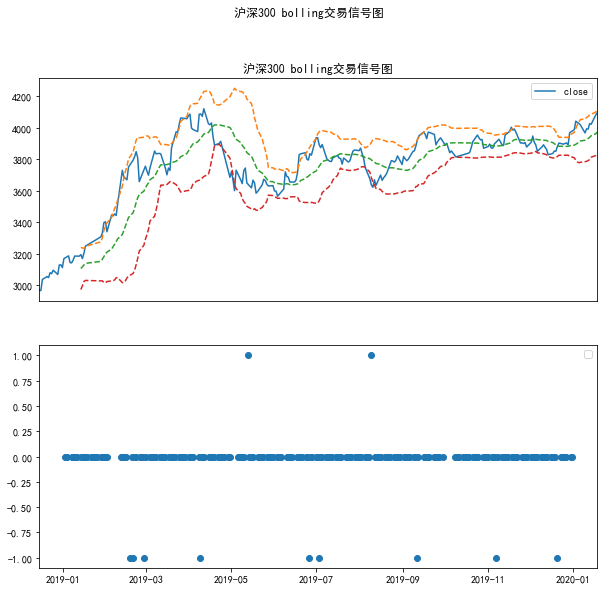

In [14]:
# 绘制交易信号图
plt.subplot(2,1,1)
plt.title('沪深300 bolling交易信号图')
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(10,10))
plt.plot(stock_index['upper'], linestyle='--')
plt.plot(stock_index['middle'], linestyle='--')
plt.plot(stock_index['lower'], linestyle='--')
plt.legend()
plt.subplot(2,1,2)
plt.plot(stock_index['signal'], marker='o', linestyle='')
plt.legend()
plt.suptitle('沪深300 bolling交易信号图')

In [16]:
# 使用position标记持仓情况，全新的循环法思路；另外一种方法；
position = 0
# 对每个交易日进行循环    
for i, item in stock_index.iterrows():   #逐行遍历；这里item就是一个Series； unpacked
    # 判断交易信号
    if item['signal'] == 1:
        # 交易信号为1，则记录仓位为1，持有多仓；
        position = 1
    elif item['signal'] == -1:
        # 交易信号为-1， 则记录仓位为-1，持有空仓；
        position = -1
    else:
        pass
    # 记录每日持仓情况
    stock_index.loc[i, 'position'] = position      #在DataFrame中自动往下填充的就是上一个产生的交易信号；关键；

In [17]:
stock_index.tail()

,open,close,high,low,volume,code,upper,middle,lower,yes_close,yes_lower,yes_upper,byes_close,byes_lower,byes_upper,signal,position
date,,,,,,,,,,,,,,,,,
2019-12-25,3988.66,3990.87,4000.56,3976.36,94938890.0,hs300,4071.171302,3931.2485,3791.325698,3992.96,3786.369049,4064.602951,3967.10,3784.151223,4056.689777,0,-1.0
2019-12-26,3993.67,4025.99,4025.99,3993.54,108860640.0,hs300,4081.400805,3939.4330,3797.465195,3990.87,3791.325698,4071.171302,3992.96,3786.369049,4064.602951,0,-1.0
2019-12-27,4029.25,4022.03,4066.80,4019.72,150926411.0,hs300,4085.818742,3949.1010,3812.383258,4025.99,3797.465195,4081.400805,3990.87,3791.325698,4071.171302,0,-1.0
2019-12-30,4015.52,4081.63,4083.69,4001.50,155971488.0,hs300,4099.386125,3961.3795,3823.372875,4022.03,3812.383258,4085.818742,4025.99,3797.465195,4081.400805,0,-1.0
2019-12-31,4077.75,4096.58,4098.14,4069.01,123264258.0,hs300,4113.890427,3973.6540,3833.417573,4081.63,3823.372875,4099.386125,4022.03,3812.383258,4085.818742,0,-1.0


No handles with labels found to put in legend.


Text(0.5, 0.98, '沪深300 bolling持仓情况')

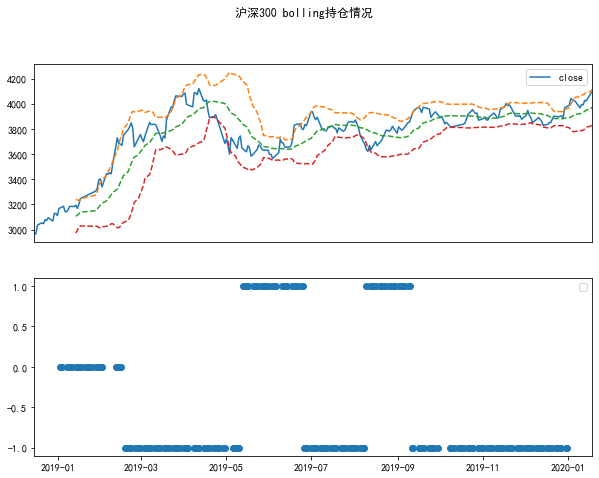

In [18]:
# 绘制持仓情况图
plt.subplot(2,1,1)
plt.gca().axes.get_xaxis().set_visible(False)
stock_index['close'].plot(figsize=(10,8))
plt.plot(stock_index['upper'], linestyle='--')
plt.plot(stock_index['middle'], linestyle='--')
plt.plot(stock_index['lower'], linestyle='--')
plt.legend()
plt.subplot(2,1,2)
plt.plot(stock_index['position'], marker='o', linestyle='')
plt.legend()
plt.suptitle('沪深300 bolling持仓情况')

 ### 3.计算策略收益及可视化

In [20]:
# 计算股票收益率
stock_index['pc_change'] = stock_index['close'].pct_change()
# 计算股票的累计收益率
stock_index['return'] = (stock_index['pc_change'] + 1).cumprod()
# 计算策略每日收益率
stock_index['strategy_return'] = stock_index['position'] * stock_index['pc_change']
# 计算策略累积收益率
stock_index['cum_strategy_return'] = (stock_index['strategy_return'] + 1).cumprod()

No handles with labels found to put in legend.


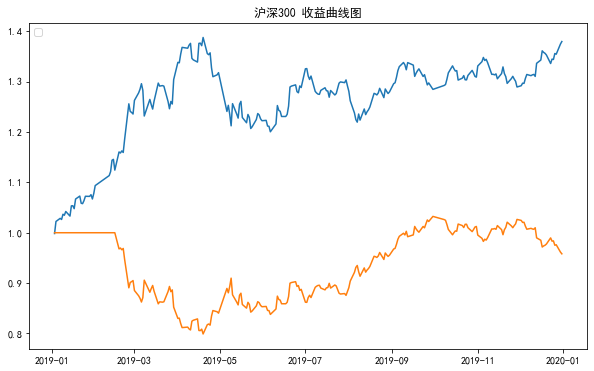

In [23]:
fig = plt.figure(figsize = (10,6))
plt.plot(stock_index['return'])
plt.plot(stock_index['cum_strategy_return'])
plt.title('沪深300 收益曲线图')
plt.legend(loc='upper left')